In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
torch.cuda.is_available()

False

In [4]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim=-1) #-1 to take softmax of last dimension

class ValueFunctionNet(nn.Module):
    def __init__(self, state_size, hidden_size):
        super(ValueFunctionNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

class PGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, vf_lr, discount ):
        self.action_size = action_size
        self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
        self.vf_net = ValueFunctionNet(state_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=actor_lr)
        self.vf_optimizer = optim.Adam(self.vf_net.parameters(), lr=vf_lr)
        self.discount = discount

    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.actor_net(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action_probs = action_probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=action_probs)
        return action

    def train(self, state_list, action_list, reward_list):

        #turn rewards into return
        trajectory_len = len(reward_list)
        return_array = np.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1,-1,-1):
            g_return = reward_list[i] + self.discount*g_return
            return_array[i] = g_return

        # create tensors
        state_t = torch.stack(state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1,1)
        return_t = torch.FloatTensor(return_array).to(device).view(-1,1)

        # get value function estimates
        vf_t = self.vf_net(state_t).to(device)
        with torch.no_grad():
            advantage_t = return_t - vf_t

        # calculate actor loss
        selected_action_prob = self.actor_net(state_t).gather(1, action_t)
        # REINFORCE loss:
        #actor_loss = torch.mean(-torch.log(selected_action_prob) * return_t)
        # REINFORCE Baseline loss:
        actor_loss = torch.mean(-torch.log(selected_action_prob) * advantage_t)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # calculate vf loss
        loss_fn = nn.MSELoss()
        vf_loss = loss_fn(vf_t, return_t)
        self.vf_optimizer.zero_grad()
        vf_loss.backward()
        self.vf_optimizer.step()

        return actor_loss.detach().cpu().numpy(), vf_loss.detach().cpu().numpy()

In [4]:
!pip install gym[atari,accept-rom-license]==0.26.0
!pip install ale-py
import gym


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 710.3/710.3 kB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 31.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.0-py3-none-any.whl size=826270 sha256=f6ed076d806899d7b4fd90b1de79ec0bdba617a0ee3720c7178c765dd7101743
  Stored in directory: /root/.cache/pip/wheels/cd/da/7c/a034980e59e34687bfb6cfa3a5f3e9b389264a0c59519c59fa
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=0853a7c6f27ef7115549c56c1d55715f9e299c82ccc578dbe66989b0b136e1cc
  Stored in directory: /root/.cache/pip/w

In [5]:

def preprocess(image):
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    return torch.from_numpy(image.astype(float).ravel()).float()


In [6]:
# initialize environment
import numpy as np
env = gym.make('Pong-v0')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 1000 # run agent for this many episodes
hidden_size = 256 # number of units in NN hidden layers
actor_lr = 0.001 # learning rate for actor
value_function_lr = 0.001 # learning rate for value function
discount = 0.99 # discount factor gamma value
reward_scale = 1 #scale reward by this amount

# create agent
agent = PGAgent(80*80, action_size, hidden_size, actor_lr, value_function_lr, discount)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


In [7]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_vf_loss = 0., 0.
print(action_size)
for ep in range(episodes):
    state, info = env.reset()
    state_list, action_list, reward_list = [], [], []

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break

    terminated = False
    truncated = False
    done = None
    # train in each episode until episode is done
    while (not terminated) and (not truncated):
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        state = preprocess(state)
        action = agent.select_action(state)

        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_length += 1
        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward*reward_scale)


        state = next_state


    stats_actor_loss, stats_vf_loss = 0., 0.
    actor_loss, vf_loss = agent.train(state_list, action_list, reward_list)
    stats_rewards_list.append((ep, total_reward, episode_length))
    stats_actor_loss += actor_loss
    stats_vf_loss += vf_loss
    total_reward = 0
    episode_length = 0
    if ep % stats_every == 0:
        print('Episode: {}'.format(ep),
            'Timestep: {}'.format(timesteps),
            'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
            'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
            'Actor Loss: {:.4f}'.format(stats_actor_loss/stats_every),
            'VF Loss: {:.4f}'.format(stats_vf_loss/stats_every))


6
Episode: 0 Timestep: 1063 Total reward: -21.0 Episode length: 1063.0 Actor Loss: -0.3351 VF Loss: 0.3767
Episode: 10 Timestep: 13047 Total reward: -20.5 Episode length: 1198.4 Actor Loss: 0.0611 VF Loss: 0.0375
Episode: 20 Timestep: 25324 Total reward: -20.1 Episode length: 1227.7 Actor Loss: 0.0044 VF Loss: 0.0906
Episode: 30 Timestep: 39194 Total reward: -19.4 Episode length: 1387.0 Actor Loss: 0.0209 VF Loss: 0.0736
Episode: 40 Timestep: 51590 Total reward: -20.3 Episode length: 1239.6 Actor Loss: -0.0605 VF Loss: 0.0317
Episode: 50 Timestep: 64369 Total reward: -20.2 Episode length: 1277.9 Actor Loss: -0.0228 VF Loss: 0.0452
Episode: 60 Timestep: 77066 Total reward: -19.8 Episode length: 1269.7 Actor Loss: -0.0078 VF Loss: 0.0298
Episode: 70 Timestep: 91029 Total reward: -19.4 Episode length: 1396.3 Actor Loss: -0.1044 VF Loss: 0.0542
Episode: 80 Timestep: 105038 Total reward: -19.6 Episode length: 1400.9 Actor Loss: 0.1126 VF Loss: 0.1028
Episode: 90 Timestep: 118932 Total rewar

Text(0, 0.5, 'Episode Reward')

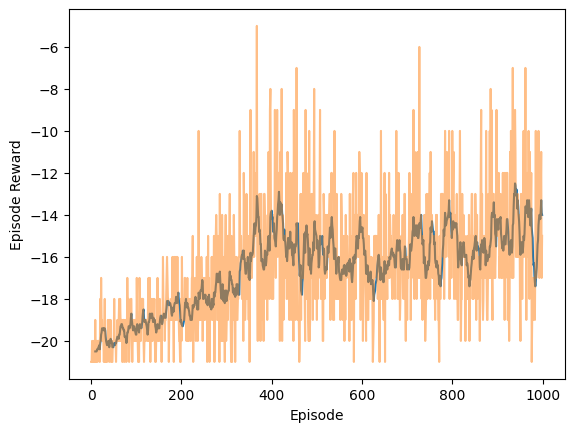

In [8]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0))
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')